# 2. Estimation de l'incertitude épistémique par inférence variationnelle: application avec Tensorflow Probability

## Importation des librairies

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Fonction linéaire simple

Dans ce premier exemple, cherchons à reproduire la fonction linéaire bruitée
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
où $\epsilon_i \sim N(0, 1)$ est $i.i.d.$ (independent and identically distributed).

In [3]:
X_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = X_train + 0.1*np.random.randn(100)[:, np.newaxis]

**Visualisation des données**

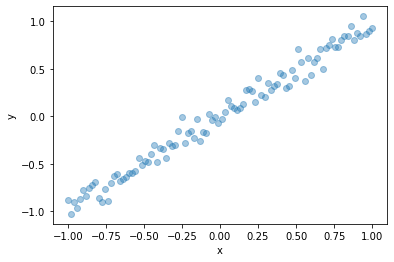

In [4]:
plt.xlabel("x")
plt.ylabel("y")
plt.scatter(X_train, y_train, alpha=0.4)
plt.show()

**Définition du prior et du posterior variationnel**

In [5]:
def prior(kernel_size, bias_size, dtype=None):
    """Prior weight distribution: N(0, 1) and not trainable"""
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))
        )
    ])
    return prior_model

In [6]:
def posterior(kernel_size, bias_size, dtype=None):
    """Variational posterior weight distribution: multivariate Gaussian with Lower triangular covariance matrix"""
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

**Définition du réseau de neurones bayésien**:
- une seule couche `DenseVariational` car problème linéaire
- la distribution du posterior variationnel va être inférée par minimisation de la diverge de KL sur une métrie donnée (ici mean-squared-error)

In [7]:
# Create linear regression model with weight uncertainty
model = Sequential([
    tfpl.DenseVariational(
        input_shape=(1,),
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        kl_weight=1/X_train.shape[0],
        kl_use_exact=True)
])
model.compile(loss=MeanSquaredError(), 
              optimizer=RMSprop(learning_rate=0.005))
model.summary()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


**Entraînement du modèle**

In [8]:
# Fit the model, just like a deterministic linear regression
history = model.fit(X_train, y_train, epochs=500, verbose=False)

In [9]:
# Check out the parameters of the prior and posterior distribution
dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [ 0.94075227 -0.01207095]
posterior covariance:  [ 0.01508673 -0.00295937]
                       [-0.00295937  0.00705639]


**Echantillonage des poids à partir de la distribution du posterior variationnelle**

In [22]:
y_models = np.stack([model(X_train) for _ in range(300)], axis=1)
y_mean = y_models.mean(axis=1)
y_std = y_models.std(axis=1)

**Visualisation de l'incertitude épistémique:**
- l'incertitude des poids se propage dans le réseau pour obtenir une incertitude sur les prédictions

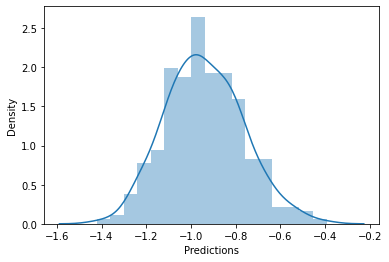

In [27]:
plt.xlabel("Predictions")
sns.distplot(y_models[0, :], bins=int(np.sqrt(300)));

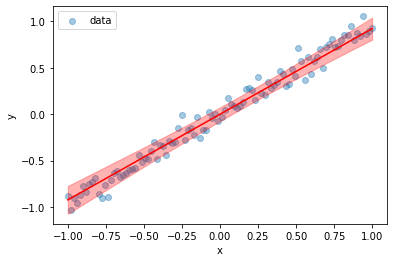

In [12]:
# Plot an ensemble of linear regressions
plt.scatter(X_train, y_train, alpha=0.4, label='data')
plt.xlabel('x') ; plt.ylabel('y')
plt.plot(X_train, y_mean, color='red')
plt.fill_between(X_train.ravel(), (y_mean-y_std).ravel(), (y_mean+y_std).ravel(), color='red', alpha=0.3)
plt.legend()
plt.show()

## Evolution de l'incertitude épistémique avec la taille du jeu d'entraînement

In [13]:
# Create two datasets, one with 100 points, another with 1000
X_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = X_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]
X_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = X_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

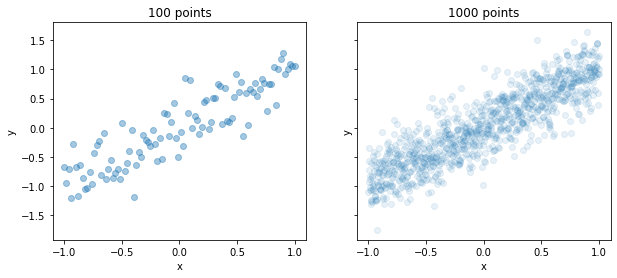

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.set_xlabel('x') ; ax1.set_ylabel('y')
ax1.scatter(X_train_100, y_train_100, alpha=0.4)
ax1.set_title("100 points")
ax2.set_xlabel('x') ; ax2.set_ylabel('y')
ax2.scatter(X_train_1000, y_train_1000, alpha=0.1)
ax2.set_title("1000 points")
plt.show()

In [15]:
# Train a model on each dataset
model_100 = Sequential([tfpl.DenseVariational(
    input_shape=(1,), 
    units=1,
    make_prior_fn=prior, 
    make_posterior_fn=posterior,
    kl_weight=1/X_train_100.shape[0]
)])
model_1000 = Sequential([tfpl.DenseVariational(
    input_shape=(1,),
    units=1,
    make_prior_fn=prior, 
    make_posterior_fn=posterior,
    kl_weight=1/X_train_1000.shape[0]
)])
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.fit(X_train_100, y_train_100, epochs=500, verbose=False)
model_1000.fit(X_train_1000, y_train_1000, epochs=50, verbose=False)

In [16]:
y_models_100 = [model_100(X_train_100) for _ in range(100)]#, axis=1)
y_mean_100 = np.mean(y_models_100, axis=0)
y_std_100 = np.std(y_models_100, axis=0)
y_models_1000 = [model_1000(X_train_1000) for _ in range(100)]#, axis=1)
y_mean_1000 = np.mean(y_models_1000, axis=0)
y_std_1000 = np.std(y_models_1000, axis=0)

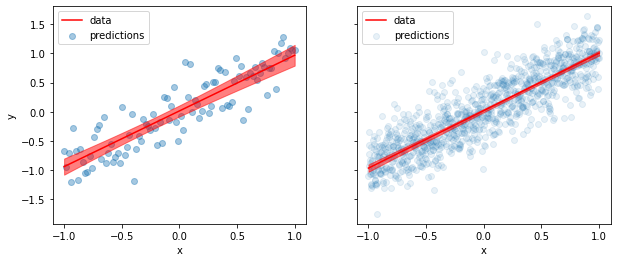

In [17]:
# Plot an ensemble of linear regressions from each model
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(X_train_100, y_train_100, color='C0', alpha=0.4)
ax1.plot(X_train_100, y_mean_100, color='red')
ax1.fill_between(X_train_100.ravel(), (y_mean_100-y_std_100).ravel(), (y_mean_100+y_std_100).ravel(), color='red', alpha=0.5)
ax1.legend(["data", "predictions"])
ax2.scatter(X_train_1000, y_train_1000, color='C0', alpha=0.1)
ax2.plot(X_train_1000, y_mean_1000, color='red')
ax2.fill_between(X_train_1000.ravel(), (y_mean_1000-y_std_1000).ravel(), (y_mean_1000+y_std_1000).ravel(), color='red', alpha=0.5)
ax1.set_xlabel('x')
ax2.set_xlabel('x')
ax1.set_ylabel('y')
ax2.legend(["data", "predictions"])